<a href="https://colab.research.google.com/github/tomonari-masada/course-nlp2020/blob/master/09_neural_machine_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09 RNNによる機械翻訳
* 下記論文にある機械翻訳手法（より少し凝ったもの）を実装する。
 * https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf

![5346-sequence-to-sequence-learning-with-neural-networks_fig1.png](https://raw.githubusercontent.com/tomonari-masada/course-nlp2020/master/5346-sequence-to-sequence-learning-with-neural-networks_fig1.png)

* 少し凝っているのは、下記論文のアイデア（の簡易版）を使っているためである。
 * https://arxiv.org/abs/1409.0473

![1409.0473_fig1.png](https://raw.githubusercontent.com/tomonari-masada/course-nlp2020/master/1409.0473_fig1.png)

* そこで、下のPyTorchのチュートリアルにあるコードを使う。
 * https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html
 * このコードはもっと複雑な仕組み（attention）を使っているが、それについては次回以降説明する。

---
* その他の参考資料

 * https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb
 * https://github.com/SethHWeidman/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb

---

**概要**
* 単語列は、`<sos>`と`<eos>`という特殊なトークンで挟んで入力する。
 * それぞれ、文の始まりと終わりを意味するトークン。
* まず、エンコーダRNNを使って、入力シーケンスを隠れ状態へとエンコードする。
 * 隠れ状態は、あらかじめ定められた次元数をもつベクトル。
* この隠れ状態と、文の始まりを表す`<sos>`トークンとを、デコーダへ入力する。
 * 以下、ひとつずつ単語トークンを生成していく。

* RNN (Recurrent Neural Networks) については、下の記事がわかりやすい。
 * https://colah.github.io/posts/2015-08-Understanding-LSTMs/

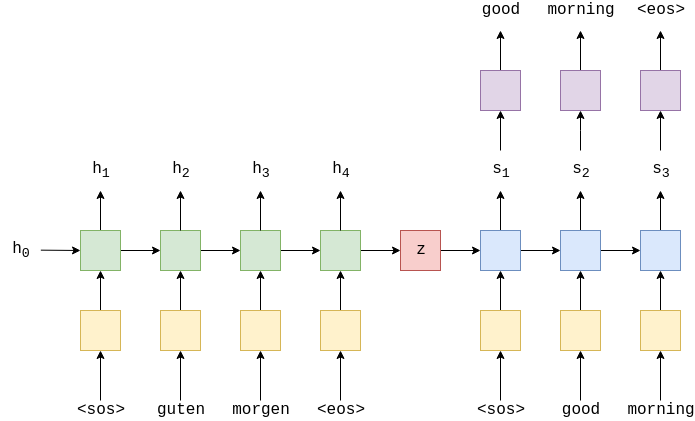

---

## 09-00 全体のための準備
* Google ColabのランタイムのタイプはGPUにしておく。
* ドイツ語から英語への翻訳をおこなうため、spaCyのドイツ語のモデルをインストールしておく。
 * spaCyの英語のモデルはGoogle Colabにはデフォルトでインストールされている。
 * https://spacy.io/usage/models

In [ ]:
! python -m spacy download de

     |████████████████████████████████| 14.9MB 846kB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907056 sha256=a2e718b723d952812dd3d1f325c4c35cdb14d5cffa4fbd220a11feaf060a7bdc
  Stored in directory: /tmp/pip-ephem-wheel-cache-9ljyiaof/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


インストールが終わったらランタイムを再起動する

## 09-01 準備

### 必要なモジュール等をインポート

In [ ]:
import sys
import random
import math
import time
from datetime import datetime

import numpy as np
import spacy

import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

### 再現性確保のための設定

In [ ]:
SEED = 123

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### spaCyのドイツ語と英語のモデルがロードできるかチェック
* ロード時にエラーが出たら、ランタイムを再起動してみよう。

In [ ]:
spacy.load("de")
spacy.load("en")

### torchtext.dataのフィールドを作成
* 翻訳元のテキストと、翻訳先のテキストそれぞれについて、フィールドを作成。
* tokenizationはいずれもspaCyにする。
* init_tokenとeos_tokenを指定する。
* 大文字はすべて小文字にしてしまう。
 * 本格的な翻訳システムを作る場合は、大文字を小文字にするのはNG。

In [ ]:
SRC = Field(tokenize = "spacy",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize = "spacy",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

### 訓練データ、検証データ、テストデータを用意する
* 今回は、Multi30k Data Repositoryというデータセットから、独英翻訳の部分を使う。 
 * https://github.com/multi30k/dataset

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'),
                                                    fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:04<00:00, 300kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 80.3kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 77.1kB/s]


In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [ ]:
print(vars(train_data.examples[0]))

{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'i', 'm', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


In [ ]:
print(train_data.examples[0].src)

['zwei', 'junge', 'weiße', 'männer', 'sind', 'i', 'm', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']


In [ ]:
print(train_data.examples[0].trg)

['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


### 語彙を構築する
* 出現頻度が1回の単語はすべて未知語としてまとめてしまう。

In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [ ]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7873
Unique tokens in target (en) vocabulary: 5893


* 語彙のうちID順で最初の２つは、やはり特殊な単語になっている。
 * `<unk>`は未知語
 * `<pad>`はパディング用の単語

In [ ]:
print(SRC.vocab.itos[:10])
print(TRG.vocab.itos[:10])

['<unk>', '<pad>', '<sos>', '<eos>', '.', 'ein', 'einem', 'in', 'eine', ',']
['<unk>', '<pad>', '<sos>', '<eos>', 'a', '.', 'in', 'the', 'on', 'man']


### デバイスを設定する
* GPUが使えるなら使う。

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### ミニバッチを取り出すイテレータを作る
* ミニバッチのshapeは、[単語列長, ミニバッチの大きさ]となる。
 * 正確には、単語列長は、ミニバッチに含まれる単語列のうち最長のものの長さ、である。
 * 最長の単語列以外の単語列は、最長の列と同じ長さになるまで、末尾にパディング用の特殊なトークンで埋められる。

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
  (train_data, valid_data, test_data),
  batch_size = BATCH_SIZE,
  device = device)

## 09-02　モデル
* エンコーダ
 * 入力として与えられた単語列をまず埋め込み、そしてRNNによって隠れ状態を表すベクトルへと変換する。
 * 今回は、bidirectionalなRNNを使う。
* デコーダ
 * エンコーダRNNから受け取った隠れ状態ベクトルを受け取って、翻訳先の言語の単語列を、RNNによって生成する。
* エンコーダ、デコーダ両方とも、LSTMではなく、GRUを使う。

seq2seq8.png

### エンコーダ
* インスタンスを作るときに指定する値の意味は以下の通り。
 * input_dim: 語彙サイズ
 * emb_dim: 単語埋め込みの次元数
 * enc_hid_dim: エンコーダの隠れ状態の次元数
 * dec_hid_dim: デコーダの隠れ状態の次元数
 * dropout: ドロップアウトの確率
* ここではLSTMではなくGRUを使う。しかも、双方向のGRUを使う。

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_dim, emb_dim,
               enc_hid_dim, dec_hid_dim, dropout):
    super().__init__()

    self.input_dim = input_dim
    self.emb_dim = emb_dim
    self.enc_hid_dim = enc_hid_dim
    self.dec_hid_dim = dec_hid_dim
    self.dropout = dropout

    self.embedding = nn.Embedding(input_dim, emb_dim)
    self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
    self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, src):
    # srcの形は[単語列長, バッチサイズ]

    embedded = self.dropout(self.embedding(src))
    # embeddedの形は[単語列長, バッチサイズ, 埋め込み次元数]

    outputs, hidden = self.rnn(embedded)
    # outputsの形は[単語列長, バッチサイズ, 隠れ状態の次元数*2]
    # hiddenの形は[レイヤー数*2, バッチサイズ, 隠れ状態の次元数]
    #   hiddenは[forward_1, backward_1, forward_2, backward_2, ...]とスタックされている。

    hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
    # hiddenの型が[バッチサイズ, デコーダの隠れ状態の次元数]に変わる

    return outputs, hidden

### デコーダ
* やはり、LSTMではなく、GRUを使う。
* 単語列を生成できる必要があるため、bidirectionalなものは使えない。
* デコーダがエンコーダから受け取る情報として、エンコーダRNNの最後の隠れ状態を使うだけではあまりうまくいかない。
* そこで今回は、エンコーダRNNの隠れ状態だけでなく、エンコーダRNNの出力ベクトル列（入力単語列に沿って得られるすべて隠れ状態）の平均も、デコーダの入力の一部として使う。
 * エンコーダRNNの出力ベクトル列を表すテンソルの形は[単語列長, バッチサイズ, 隠れ状態の次元数*2]である。
 * これの単語列長の方向に平均をとって、デコーダへの入力の一部として利用する。

In [ ]:
class Decoder(nn.Module):
  def __init__(self, output_dim, emb_dim,
               enc_hid_dim, dec_hid_dim, dropout):
    super().__init__()

    self.emb_dim = emb_dim
    self.enc_hid_dim = enc_hid_dim
    self.dec_hid_dim = dec_hid_dim
    self.output_dim = output_dim
    self.dropout = dropout

    self.embedding = nn.Embedding(output_dim, emb_dim)
    self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
    self.out = nn.Linear(dec_hid_dim + (enc_hid_dim * 2) + emb_dim, output_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, input, decoder_hidden, mean_encoder_output):
    # inputの形は[単語列長, バッチサイズ]
    input = input.unsqueeze(0)

    embedded = self.dropout(self.embedding(input))
    # embeddedの形は[単語列長, バッチサイズ, 埋め込み次元数]

    # mean_encoder_outputの型は[1, バッチサイズ, エンコーダ隠れ状態次元数*2]
    rnn_input = torch.cat((mean_encoder_output, embedded), dim = 2)
    output, decoder_hidden = self.rnn(rnn_input, decoder_hidden.unsqueeze(0))
    embedded = embedded.squeeze(0)
    output = output.squeeze(0)
    mean_encoder_output = mean_encoder_output.squeeze(0)
    output = self.out(torch.cat((output, mean_encoder_output, embedded), dim = 1))

    return output, decoder_hidden.squeeze(0)

### RNNの重みを初期化するための関数
* 重みは標準偏差0.01の正規乱数で初期化。
* バイアスはゼロで初期化。

In [ ]:
def init_weights(m):
  for name, param in m.named_parameters():
    if 'weight' in name:
      nn.init.normal_(param.data, mean=0, std=0.01)
    else:
      nn.init.constant_(param.data, 0)

### エンコーダとデコーダをまとめる
* エンコーダとデコーダをまとめて扱うためのクラスを定義する。

In [ ]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, device):
    super().__init__()
       
    self.encoder = encoder
    self.decoder = decoder
    self.device = device

  def forward(self, src, trg, teacher_forcing_ratio = 0.5, no_length_limit = False):
    # srcとtrgの形は[単語列長, バッチサイズ]
    batch_size = src.shape[1]
    max_len = trg.shape[0]
    if no_length_limit: max_len *= 2
    trg_vocab_size = self.decoder.output_dim

    outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(device)

    encoder_outputs, hidden = self.encoder(src)

    # デコーダへの最初の入力トークンは<sos>トークン
    output = trg[0,:]
    for t in range(1, max_len):
      mean_encoder_output = encoder_outputs.mean(0, keepdim=True)
      output, hidden = self.decoder(output, hidden, mean_encoder_output)
      outputs[t] = output
      teacher_force = torch.rand(1).item() < teacher_forcing_ratio
      top1 = output.max(1)[1]
      output = (trg[t] if teacher_force else top1)

    return outputs

### 定数の定義

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

ENC_EMB_DIM = 32
DEC_EMB_DIM = 32
ENC_HID_DIM = 64
DEC_HID_DIM = 64
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

### モデルのインスタンスを作る

In [ ]:
model = Seq2Seq(
    Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT),
    Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT),
    device
    ).to(device)

### モデルの重みを初期化

In [ ]:
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7873, 32)
    (rnn): GRU(32, 64, bidirectional=True)
    (fc): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 32)
    (rnn): GRU(160, 64)
    (out): Linear(in_features=224, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

### optimizerの準備
* Adamを使う

In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,855,717 trainable parameters


### 損失関数

In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

## 09-03 学習や評価を補助するための関数

### 訓練のための関数

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
  model.train()

  epoch_loss = 0
  for _, batch in enumerate(iterator):
    src = batch.src
    trg = batch.trg

    optimizer.zero_grad()
    output = model(src, trg)
    output = output[1:].view(-1, output.shape[-1])
    trg = trg[1:].view(-1)

    loss = criterion(output, trg)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

    epoch_loss += loss.item()

  return epoch_loss / len(iterator)

### 評価のための関数

In [ ]:
def evaluate(model, iterator, criterion):
  model.eval()

  epoch_loss = 0
  with torch.no_grad():
    for _, batch in enumerate(iterator):
      src = batch.src
      trg = batch.trg

      output = model(src, trg, 0) # teacher forcingは無効にする
      output = output[1:].view(-1, output.shape[-1])
      trg = trg[1:].view(-1)

      loss = criterion(output, trg)
      epoch_loss += loss.item()

  return epoch_loss / len(iterator), output

### 経過時間を表示する関数

In [ ]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

### チェックポイントの保存・読み込みの関数

In [ ]:
def save_checkpoint(path, model, optimizer, epoch):
  torch.save({
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'epoch': epoch,
      }, path)
  
def load_checkpoint(path, model, optimizer):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return checkpoint['epoch']

## 09-04 学習の実行
* チェックポイントを保存するパスは各自設定してください。

In [ ]:
# 下記のパスは、あくまでも、例です。
LOAD_PATH = '/content/drive/My Drive/2020Courses/NLP/08_NMT_20200826.tar' 
SAVE_PATH = '/content/drive/My Drive/2020Courses/NLP/08_NMT.tar'

init_epoch = 0
try:
  init_epoch = load_checkpoint(LOAD_PATH, model, optimizer)
except:
  pass
init_epoch += 1

N_EPOCHS = 100
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(init_epoch, init_epoch + N_EPOCHS):

  start_time = time.time()
  train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
  valid_loss, _ = evaluate(model, valid_iterator, criterion)
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if epoch % 10 == 0:
    save_checkpoint(SAVE_PATH, model, optimizer, epoch)

  print(f'Epoch: {epoch:02} | Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 20 | Time: 0m 24s
	Train Loss: 2.379 | Train PPL:  10.790
	 Val. Loss: 3.912 |  Val. PPL:  50.013
Epoch: 21 | Time: 0m 24s
	Train Loss: 2.375 | Train PPL:  10.753
	 Val. Loss: 3.932 |  Val. PPL:  51.026
Epoch: 22 | Time: 0m 24s
	Train Loss: 2.365 | Train PPL:  10.642
	 Val. Loss: 3.899 |  Val. PPL:  49.330
Epoch: 23 | Time: 0m 24s
	Train Loss: 2.348 | Train PPL:  10.462
	 Val. Loss: 3.951 |  Val. PPL:  51.974
Epoch: 24 | Time: 0m 24s
	Train Loss: 2.354 | Train PPL:  10.526
	 Val. Loss: 3.901 |  Val. PPL:  49.432
Epoch: 25 | Time: 0m 24s
	Train Loss: 2.344 | Train PPL:  10.428
	 Val. Loss: 3.955 |  Val. PPL:  52.179
Epoch: 26 | Time: 0m 24s
	Train Loss: 2.340 | Train PPL:  10.381
	 Val. Loss: 3.964 |  Val. PPL:  52.660
Epoch: 27 | Time: 0m 24s
	Train Loss: 2.330 | Train PPL:  10.275
	 Val. Loss: 3.966 |  Val. PPL:  52.770
Epoch: 28 | Time: 0m 24s
	Train Loss: 2.351 | Train PPL:  10.498
	 Val. Loss: 3.950 |  Val. PPL:  51.924
Epoch: 29 | Time: 0m 24s
	Train Loss: 2.342 | Train PPL

KeyboardInterrupt: ignored

## 09-05 テストセット上で評価

### 定量的評価

In [ ]:
test_loss, output = evaluate(model, test_iterator, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.024 | Test PPL:  55.904 |
torch.Size([3536])
a a people a two two three a a two a a a a a two an a people the a a a men the a two a two a two two a a a people people a the a a a a two two a a five a a a closeup a a a a a a an a four two a a a a a a man a a five a two a the a a a a a a a three people a a a a a two a three a a a a two a three a a an a man man are boy girls men children black group athletes man woman uniformed man family people asian man sit goalie man woman young are basketball girl asian bull people man basketball men university man man in in man lady little man child young children children woman young people teenager quarterback surfer of man woman football <unk> man family adult white men girls <unk> man man few young man in female man football man people child girl man woman woman young mom woman woman men standing girl woman little woman child female man men black person woman man young man people woman man older man wearing wearing in in , stand in 

### 定性的評価

In [ ]:
load_checkpoint(LOAD_PATH, model, optimizer)

19

In [ ]:
test_batch = list(test_iterator)[0]
outputs = model(test_batch.src, test_batch.trg, 0, True)
for j in range(test_batch.src.shape[1]):
  print('>', ' '.join([SRC.vocab.itos[i] for i in test_batch.src[1:, j]]))
  print('=', ' '.join([TRG.vocab.itos[i] for i in test_batch.trg[1:, j]]))
  print('<', ' '.join([TRG.vocab.itos[i] for i in outputs[1:, j, :].squeeze().max(1)[1]]))
  print('-' * 64)

> frau mit brille in einem pinken hemd . <eos>
= woman in a pink shirt and wearing glasses . <eos> <pad> <pad> <pad>
< girl in tye - shirt with a girl in shirts shirts in a shirts . <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <e